# Assignment 1: Identify clusters using (Node2Vec Embedding, Spectral, and GCN) embeddings(Assignment)


##### Group Members:
1. Kummitha Jhanavi (CS21BTECH11032)
2. Potta Vennela (CS21BTECH11046)
3. Vinjam Aswitha (MA21BTECH11018)
4. Pundi Bindusree (CS21BTECH11048)
5. K Vivek Kumar (CS21BTECH11026)

### Data Preprocessing

In [1]:
# Importing Necessary Packages
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import silhouette_score
import warnings
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Loading the datasets
df = pd.read_csv('Payments.csv')

In [3]:
df.head()

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396


In [4]:
# Initializing a networkx graph
G = nx.DiGraph()

In [5]:
# Building graph with nodes, edges and corresponding weights
for index, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    value = row['Amount']
    G.add_edge(sender, receiver, weight=value)

In [6]:
for node in list(G.nodes)[:10]:
    indegree = G.in_degree(node)
    outdegree = G.out_degree(node)
    print(f"Node {node}: Indegree = {indegree}, Outdegree = {outdegree}")

Node 1309: Indegree = 33, Outdegree = 75
Node 1011: Indegree = 24, Outdegree = 22
Node 1259: Indegree = 0, Outdegree = 30
Node 1568: Indegree = 0, Outdegree = 4
Node 1147: Indegree = 34, Outdegree = 62
Node 1393: Indegree = 0, Outdegree = 3
Node 1039: Indegree = 29, Outdegree = 41
Node 1210: Indegree = 6, Outdegree = 6
Node 1005: Indegree = 2, Outdegree = 4
Node 1042: Indegree = 6, Outdegree = 5


### Node2Vec Clustering

Node2Vec clustering is a graph-based clustering technique that utilizes node embeddings generated by the Node2Vec algorithm. It involves representing each node in a graph as a low-dimensional vector, capturing its structural context within the network. These embeddings are then clustered using traditional clustering algorithms such as KMeans or spectral clustering, enabling the identification of communities or groups of nodes with similar connectivity patterns.

In [7]:
# Generate node embeddings using Node2Vec algorithm
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

In [27]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [28]:
node_ids = model.wv.index_to_key
node_embeddingss = np.array([model.wv[node_id] for node_id in node_ids])

In [30]:
pca = PCA(n_components=2)
node_embeddings = pca.fit_transform(node_embeddingss)

In [31]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(node_embeddings)

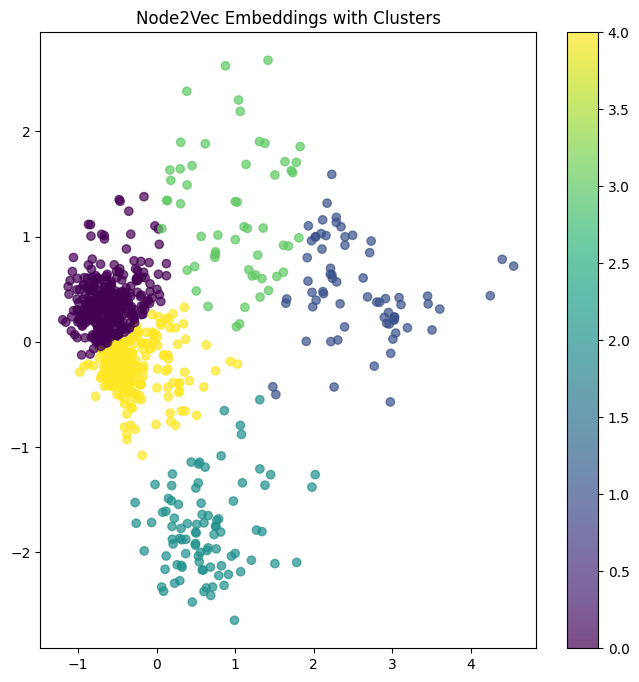

In [32]:
plt.figure(figsize=(8, 8))
plt.scatter(node_embeddings[:, 0], node_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('Node2Vec Embeddings with Clusters')
plt.colorbar()
plt.savefig("node2vec.png")
plt.show()

### Spectral Embedding Clustering

Spectral embedding is a technique that maps nodes of a graph into a lower-dimensional space based on the graph's spectral properties. It leverages the eigenvalues and eigenvectors of the graph Laplacian matrix to embed nodes. This embedding preserves the structural characteristics of the graph, making it useful for tasks like clustering and visualization.

In [33]:
# Compute spectral embeddings with 64 components and 'nearest_neighbors' affinity.
spectral_embedding = SpectralEmbedding(n_components=64, affinity='nearest_neighbors')
node_embeddings_spectral = spectral_embedding.fit_transform(nx.to_numpy_array(G))

In [34]:
# Perform dimensionality reduction using Principal Component Analysis (PCA) to reduce the dimensionality of spectral node embeddings to 2 dimensions.
pca = PCA(n_components=2)
node_embeddings_spectral_reduced = pca.fit_transform(node_embeddings_spectral)

In [35]:
# Applying the kmeans algorithm
kmeans_spectral = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels_spectral = kmeans_spectral.fit_predict(node_embeddings_spectral_reduced)

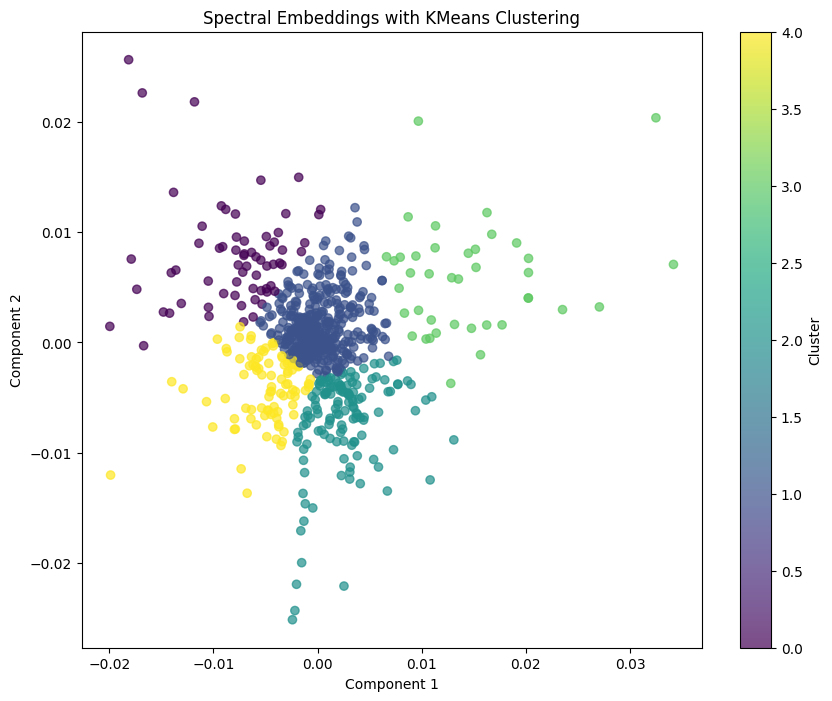

In [36]:
# Plotting the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(node_embeddings_spectral_reduced[:, 0], 
                       node_embeddings_spectral_reduced[:, 1], 
                       c=cluster_labels_spectral,
                       cmap='viridis', 
                       alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('Spectral Embeddings with KMeans Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig("se.png")
plt.show()

### GCN Clustering

Graph Convolutional Network (GCN) clustering is a method that utilizes neural networks to perform clustering on graph-structured data. It leverages message passing techniques to propagate information across the graph, enabling nodes to aggregate and update their features based on the features of neighboring nodes. GCNs can learn node representations that capture the graph's structural information, facilitating tasks such as node clustering and classification.

In [37]:
# Create node features (sender and receiver IDs) and edge indices
senders = df['Sender'].values
receivers = df['Receiver'].values
amounts = df['Amount'].values

In [38]:
# Get unique sender and receiver
nodes = np.unique(np.concatenate((senders, receivers)))

In [39]:
# Map sender and receiver IDs to node indices
node_to_index = {node: i for i, node in enumerate(nodes)}
sender_indices = np.array([node_to_index[sender] for sender in senders])
receiver_indices = np.array([node_to_index[receiver] for receiver in receivers])

In [40]:
# Create edge indices tensor
edges = np.vstack((sender_indices, receiver_indices))
edges = torch.tensor(edges, dtype=torch.long)

In [41]:
# Create node features tensor (assuming one-hot encoding of node IDs)
num_nodes = len(nodes)
node_features = np.eye(num_nodes)  # One-hot encoding of node IDs
node_features = torch.tensor(node_features, dtype=torch.float)

In [42]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [43]:
# Initialize the model
in_channels = node_features.size(1)
hidden_channels = 64
out_channels = 32
model = GCN(in_channels, hidden_channels, out_channels)

In [44]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [45]:
# Training loop
num_epochs = 100
num_clusters = 5

In [46]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(node_features, edges)
    # Perform clustering on the output embeddings (out)
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(out.detach().numpy())
    # Convert labels to PyTorch tensor
    y = torch.tensor(labels, dtype=torch.long)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()

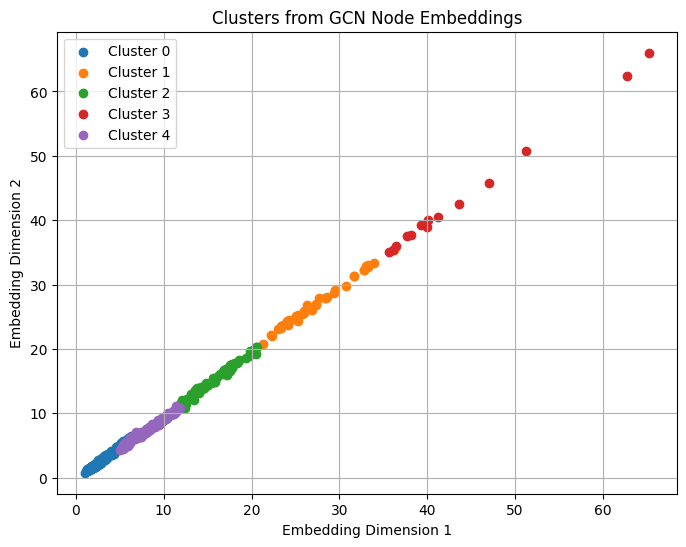

In [47]:
# Plotting the clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    plt.scatter(out[cluster_indices, 0].detach().numpy(), out[cluster_indices, 1].detach().numpy(), label=f'Cluster {i}')
plt.title('Clusters from GCN Node Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.grid(True)
plt.savefig("gcn.png")
plt.show()